In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [71]:
import davesci as ds

In [3]:
import jaydebeapi as jay

In [2]:
datafile = "/Users/yanchunyang/Documents/datafiles/ltv/"

In [15]:
predict_file = "dftotal.csv"
actual_file = "testdata.csv"

In [4]:
def read_from_snowflake(sql_str):
    with open('/Users/yanchunyang/pwd/snowflake.passphrase', 'r') as f:
        passphrase = f.read().strip()
    username = "yanchun.yang@dave.com"
    password = "abc"
    jdbcpath = "/Users/yanchunyang/lib/jdbc/snowflake-jdbc-3.13.8.jar"
    jdbc_driver_name = "net.snowflake.client.jdbc.SnowflakeDriver"
    hostname= "qc63563.snowflakecomputing.com"
    role = "FUNC_ACCOUNTING_USER"
    warehouse = "ACCOUNTING_WH"
    keyfile = "/Users/yanchunyang/.ssh/snowflake.p8"

    conn_string = f'jdbc:snowflake://qc63563.snowflakecomputing.com?role={role}&warehouse={warehouse}&private_key_file={keyfile}&private_key_file_pwd={passphrase}'

    conn = jay.connect(jdbc_driver_name, conn_string, {'user': username , 'password': password }, jars=jdbcpath)

#  Currently python can't interpret correctly the result returned from JDBC to connect Snowflake so we have to switch back to JSON rather than ARROW format
# It can be done at session level
    session_set = "ALTER SESSION SET JDBC_QUERY_RESULT_FORMAT='JSON'"
    curs = conn.cursor()
    curs.execute(session_set)

    curs.execute(sql_str)
    result = curs.fetchall()
    return result

In [78]:
sql_all = "select * from ANALYTIC_DB.MODEL_OUTPUT.statistical_training_result"

In [5]:
!source ~/.profile

In [75]:
SNOWFLAKE_ROLE = 'FUNC_ACCOUNTING_USER'
SNOWFLAKE_WAREHOUSE = 'DAVE_USER_WH'
con = ds.snowflake_connect(warehouse=SNOWFLAKE_WAREHOUSE, role=SNOWFLAKE_ROLE)

In [79]:
df_all = pd.read_sql_query(sql_all, con)

/Users/yanchunyang/miniforge3/envs/general/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [80]:
df_all.shape

(2770587, 17)

In [81]:
df_all.head(10)

,USERID,PLATFORM,ATTRIBUTION,NETWORK,FIRST_TRANS,PRED_NUM,T_VALUE,FREQUENCY,PROB_ALIVE,PREDICT_CLV,TRANS_NUM,REAL_REVENUE,START_DATE,START_MONTH,PREDICT_LABEL,ACTUAL_LABEL,ACTIVE_LABEL
0,11884416,ios,ORGANIC,Organic,0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00,2021-10-30,2021-10-01,0,0,0
1,11857531,ios,PAID,bytedanceglobal_int,0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00,2021-10-27,2021-10-01,0,0,0
2,10880784,android,PAID,Facebook,2021-06-27,3.878073,34.783987,4.0,0.892023,34.831377,2.0,4.88,2021-06-26,2021-06-01,1,1,1
3,10123692,ios,PAID,Snapchat,0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00,2021-03-08,2021-03-01,0,0,0
4,10409193,android,ORGANIC,Organic,0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00,2021-04-23,2021-04-01,0,0,0
5,10781178,0,UNDETERMINED,UNDETERMINED,0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00,2021-06-12,2021-06-01,0,0,0
6,10220732,android,PAID,Snapchat,2021-07-21,2.551760,12.639138,2.0,0.895830,15.562680,0.0,0.00,2021-03-26,2021-03-01,1,0,1
7,10845069,ios,ORGANIC,Organic,0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00,2021-06-21,2021-06-01,0,0,0
8,11234166,android,PAID,Adwords,0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00,2021-08-10,2021-08-01,0,0,0
9,11627095,android,PAID,Adwords,2021-09-30,0.594407,3.271883,1.0,0.524367,4.149381,0.0,0.00,2021-09-30,2021-09-01,1,0,1


In [83]:
predict = df_all.loc[df_all['PREDICT_LABEL'] == 1, :]

In [99]:
predict_month = predict.groupby(['START_MONTH']).agg({'T_VALUE':np.mean, 'REAL_REVENUE':np.mean}).reset_index()

In [100]:
predict_month

,START_MONTH,T_VALUE,REAL_REVENUE
0,2021-01-01,18.481497,16.972098
1,2021-02-01,20.383314,18.764501
2,2021-03-01,18.732009,16.769095
3,2021-04-01,17.139789,14.306515
4,2021-05-01,19.151830,16.293621
5,2021-06-01,23.257874,20.263287
6,2021-07-01,26.410605,23.534008
7,2021-08-01,27.643953,25.148904
8,2021-09-01,28.929829,27.137216


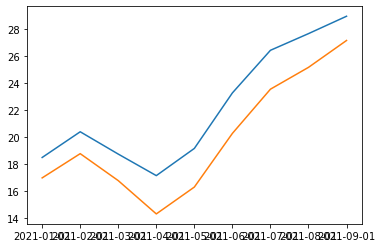

In [102]:
plt.plot(predict_month['START_MONTH'], predict_month['T_VALUE'])
plt.plot(predict_month['START_MONTH'], predict_month['REAL_REVENUE'])

In [84]:
predict.shape

(550621, 17)

In [86]:
np.sum(predict['REAL_REVENUE'])/predict.shape[0]

19.88817170067977

In [87]:
np.sum(predict['T_VALUE'])/predict.shape[0]

22.231278505324745

In [88]:
np.mean(predict['PREDICT_CLV'])

17.05616977844516

In [93]:
predict.loc[predict['ACTUAL_LABEL'] == 0,:].shape[0]/predict.shape[0]

0.6288172808519835

In [91]:
predict.loc[predict['PRED_NUM'] < 1,:].shape[0]/predict.shape[0]

0.5195152382491769

In [92]:
np.mean(predict['PROB_ALIVE'])

0.6615194851003784

In [94]:
22.23/0.6288

35.353053435114504

In [103]:
22.23/0.5195

42.79114533205005

In [96]:
19.89/(1-0.6615)

58.759231905465285

In [10]:
columns = ['userid', 'startdate', 'platform', 'attribution', 'network']

In [12]:
df = pd.DataFrame(df_all, columns=columns)

In [13]:
df.shape

(3005400, 5)

In [44]:
predict_df = pd.read_csv(datafile + predict_file, header=0)
actual_df = pd.read_csv(datafile + actual_file)
predict_update = predict_df.loc[:, ['userid', 'pred_num', 't_value', 'frequency', 'prob_alive']]
actual_update = actual_df.loc[:, ['userid', 'trans_num', 'real_revenue']]

In [45]:
combine_1 = pd.merge(df, predict_df, on=['userid'], how='left')
combine_2 = pd.merge(combine_1, actual_df, on=['userid'], how='left')

In [46]:
combine_2 = combine_2.fillna(0)

In [47]:
combine_2 = combine_2.drop(['Unnamed: 0.1', 'Unnamed: 0_x','Unnamed: 0_y'], axis=1)

In [27]:
combine_2.columns

Index(['userid', 'startdate', 'platform', 'attribution', 'network',
       'first_trans', 'frequency', 'T', 'recency', 'monetary', 'pred_num',
       'monetary_update', 'prob_alive', 'expected_monetary', 't_value',
       'trans_num', 'real_revenue'],
      dtype='object')

In [35]:
combine_2.head(2)

,userid,startdate,platform,attribution,network,first_trans,frequency,T,recency,monetary,...,prob_alive,expected_monetary,t_value,trans_num,real_revenue,start_date,start_month,predict_label,actual_label,active_label
0,11670673,2021-10-06,ios,ORGANIC,Organic,2021-10-29,2.0,95.0,24.0,4.156667,...,0.421666,5.596436,6.929668,0.0,0.0,2021-10-06,2021-10-01,1,0,1
1,11568202,2021-09-23,ios,PAID,Snapchat,0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,2021-09-23,2021-09-01,0,0,0


In [48]:
combine_2['start_date'] = pd.to_datetime(combine_2['startdate'])

In [49]:
combine_2['start_month'] = combine_2['start_date'].apply(lambda x: x.strftime('%Y-%m-01'))

In [50]:
combine_2['predict_label'] = combine_2['first_trans'].apply(lambda x: 1 if x !=0 else 0)
combine_2['actual_label'] = combine_2['trans_num'].apply(lambda x: 1 if x != 0 else 0)

In [51]:
combine_2['tmp_label'] = combine_2['predict_label'] + combine_2['actual_label']
combine_2['active_label'] = combine_2['tmp_label'].apply(lambda x: 1 if x !=0 else 0)
combine_2 = combine_2.drop(['tmp_label'], axis=1)

In [64]:
pv_churn = combine_2.groupby(['start_month']).agg({'userid': 'count', 'active_label': 'sum'}).reset_index()

NameError: name 'combine_2' is not defined

In [53]:
pv_churn['rate'] = pv_churn['active_label'] / pv_churn['userid']

In [54]:
combine_2.loc[combine_2['start_month']=='2022-01-01',:].head(4)

,userid,startdate,platform,attribution,network,first_trans,frequency,T,recency,monetary,...,prob_alive,expected_monetary,t_value,trans_num,real_revenue,start_date,start_month,predict_label,actual_label,active_label
26,12427970,2022-01-15,ios,PAID,Apple Search Ads,0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.00000,0.0,0.00,2022-01-15,2022-01-01,0,0,0
42,12347691,2022-01-04,android,PAID,bytedanceglobal_int,2022-01-04,0.0,28.0,0.0,4.99,...,1.0,4.99,11.08115,1.0,5.99,2022-01-04,2022-01-01,1,1,1
67,12554425,2022-01-31,android,PAID,Adwords,0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.00000,0.0,0.00,2022-01-31,2022-01-01,0,0,0
80,12536510,2022-01-29,ios,PAID,Apple Search Ads,0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.00000,4.0,23.46,2022-01-29,2022-01-01,0,1,1


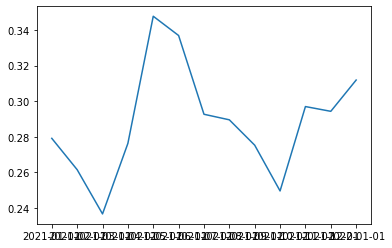

In [55]:
plt.plot(pv_churn['start_month'], pv_churn['rate'])

In [56]:
dftmp = combine_2.loc[combine_2['predict_label'] == 1, ]
predict_bymonth = dftmp.groupby(['start_month']).agg({'t_value': np.mean, 'real_revenue': np.mean}).reset_index()

<AxesSubplot:>

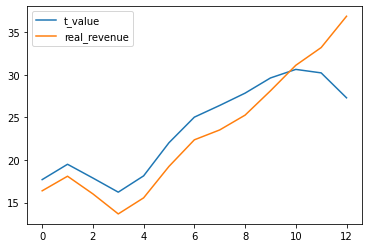

In [57]:
predict_bymonth.plot()

In [61]:
dftmp['actual_retention'] = dftmp['real_revenue'].apply(lambda x: 1 if int(x) > 0 else 0)

/var/folders/d1/rw6rwxz927g254dvggnj0jpr0000gn/T/ipykernel_88305/2688319310.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftmp['actual_retention'] = dftmp['real_revenue'].apply(lambda x: 1 if int(x) > 0 else 0)


In [62]:
predict_retention = dftmp.groupby(['start_month']).agg({'prob_alive':np.mean, 'actual_retention':np.mean})

In [63]:
predict_retention

NameError: name 'predict_retention' is not defined

<AxesSubplot:xlabel='start_month'>

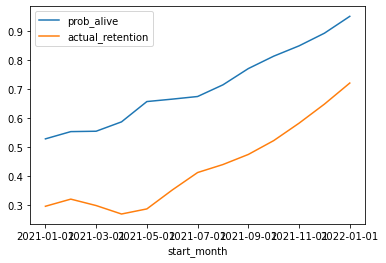

In [63]:
predict_retention.plot()

In [64]:
combine_2.columns

Index(['userid', 'startdate', 'platform', 'attribution', 'network',
       'first_trans', 'frequency', 'T', 'recency', 'monetary', 'pred_num',
       'monetary_update', 'prob_alive', 'expected_monetary', 't_value',
       'trans_num', 'real_revenue', 'start_date', 'start_month',
       'predict_label', 'actual_label', 'active_label'],
      dtype='object')

In [65]:
dftmp.head(4)

,userid,startdate,platform,attribution,network,first_trans,frequency,T,recency,monetary,...,t_value,trans_num,real_revenue,start_date,start_month,predict_label,actual_label,active_label,actualchurn,actual_retention
0,11670673,2021-10-06,ios,ORGANIC,Organic,2021-10-29,2.0,95.0,24.0,4.156667,...,6.861211,0.0,0.00,2021-10-06,2021-10-01,1,0,1,0,0
3,11231405,2021-08-10,android,PAID,Adwords,2021-08-10,21.0,175.0,174.0,4.628636,...,91.218055,4.0,23.96,2021-08-10,2021-08-01,1,1,1,1,1
6,10972388,2021-07-07,ios,PAID,Apple Search Ads,2021-12-08,2.0,55.0,25.0,4.990000,...,23.842932,0.0,0.00,2021-07-07,2021-07-01,1,0,1,0,0
7,11355457,2021-08-26,ios,ORGANIC,Organic,2021-10-06,1.0,118.0,93.0,3.990000,...,11.093794,0.0,0.00,2021-08-26,2021-08-01,1,0,1,0,0


In [66]:
predict_bymonthplatform = dftmp.groupby(['start_month', 'platform']).agg({'t_value': np.mean, 'real_revenue': np.mean}).reset_index()

In [69]:
predict_bymonthplatform_ios = predict_bymonthplatform.loc[predict_bymonthplatform['platform']=='ios',:]

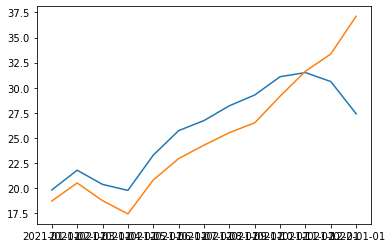

In [87]:
plt.plot(predict_bymonthplatform_ios['start_month'], predict_bymonthplatform_ios['t_value'])
plt.plot(predict_bymonthplatform_ios['start_month'],  predict_bymonthplatform_ios['real_revenue'])

In [71]:
predict_bymonthplatform_android = predict_bymonthplatform.loc[predict_bymonthplatform['platform']=='android',:]

<AxesSubplot:>

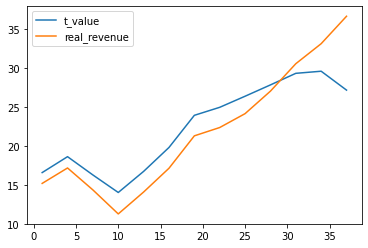

In [72]:
predict_bymonthplatform_android.plot()

In [73]:
predict_bymonthplatform.head(5)

,start_month,platform,t_value,real_revenue
0,2021-01-01,0,7.850212,5.248767
1,2021-01-01,android,16.564829,15.176519
2,2021-01-01,ios,19.831606,18.732509
3,2021-02-01,0,8.116141,6.001573
4,2021-02-01,android,18.605088,17.157173


In [82]:
predict_pivot = predict_bymonthplatform.loc[predict_bymonthplatform['platform'].isin(['ios', 'android']),['t_value', 'start_month', 'platform']]

In [83]:
predict_df = pd.pivot_table(predict_pivot, index=['start_month'], columns='platform', values='t_value', aggfunc='sum')

In [84]:
predict_df

platform,android,ios
start_month,,
2021-01-01,16.564829,19.831606
2021-02-01,18.605088,21.798804
2021-03-01,16.259466,20.387722
2021-04-01,14.012981,19.790171
2021-05-01,16.718970,23.290099
2021-06-01,19.785947,25.737430
2021-07-01,23.907261,26.736917
2021-08-01,24.933536,28.207124
2021-09-01,26.354483,29.281975


<AxesSubplot:xlabel='start_month'>

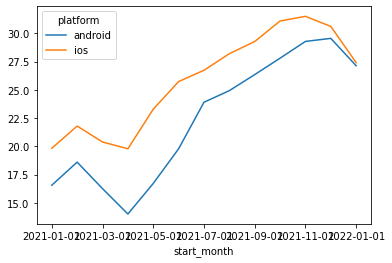

In [85]:
predict_df.plot()

In [7]:
df = pd.read_csv(datafile + "advance_user.csv", header=0)

In [8]:
df.tail(4)

,Unnamed: 0,USER_ID,FIRST_TRANS,FREQUENCY,T,RECENCY,MONETARY
687150,687150,12258254,2021-12-22,0,10,0,3.240
687151,687151,12246582,2021-12-21,1,11,8,11.365
687152,687152,12255833,2021-12-21,0,11,0,16.990
687153,687153,12250544,2021-12-21,0,11,0,5.240


In [9]:
adf = pd.read_csv(datafile + "testdata.csv", header=0)

In [10]:
adf.columns

Index(['Unnamed: 0', 'USER_ID', 'TRANS_NUM', 'REAL_REVENUE'], dtype='object')

In [12]:
datafile

'/Users/yanchunyang/Documents/datafiles/ltv/'

In [14]:
all_user = pd.read_csv(datafile + "users_property.csv", header=0)

In [15]:
all_user.columns

Index(['Unnamed: 0', 'USER_ID', 'STARTDATE', 'PLATFORM', 'ATTRIBUTION',
       'NETWORK'],
      dtype='object')

In [46]:
predict = pd.read_csv(datafile + "dftotal.csv")

In [47]:
predict.head(10)

,Unnamed: 0,index_name,userid,first_trans,frequency,T,recency,monetary,pred_num,monetary_update,prob_alive,expected_monetary,predict_clv,t_value
0,0,0,9560006,2021-08-10,8,144,129,5.990000,8.727374,5.990000,0.876967,6.071350,41.580169,52.986938
1,1,1,10214684,2021-04-18,13,258,243,5.169286,8.430613,5.169286,0.907123,5.426195,38.269801,45.746147
2,2,2,10682172,2021-05-29,4,217,42,5.790000,0.058841,5.790000,0.019113,6.013245,0.120264,0.353825
3,3,3,10531540,2021-05-09,17,237,222,5.823333,11.587426,5.823333,0.892857,5.902913,53.719229,68.399562
4,4,4,11057934,2021-07-19,5,166,150,1.990000,5.228664,1.990000,0.893605,3.916474,18.853808,20.477927
5,5,5,11463561,2021-09-10,10,113,106,5.035455,13.116343,5.035455,0.910623,5.386134,50.686384,70.646382
6,6,6,9580210,2021-01-06,7,360,354,2.271250,3.661057,2.271250,0.933608,3.747760,14.115702,13.720763
7,7,7,10313055,2021-04-17,15,259,217,5.490000,8.312395,5.490000,0.628826,5.650365,31.686902,46.968064
8,8,8,10953405,2021-07-05,20,180,172,5.751905,17.219477,5.751905,0.919800,5.833924,73.759076,100.457126
9,9,9,9583235,2021-02-28,22,307,305,17.511739,12.035036,17.511739,0.961714,15.714392,157.833676,189.123283


In [48]:
np.mean(predict['t_value'])

23.659784027198146

In [49]:
np.mean(predict['predict_clv'])

24.741111189561778

In [21]:
np.mean(predict['prob_alive'])

0.7086157734166831

In [53]:
predict['retention'] = predict['pred_num'].apply(lambda x: 1 if x >=1 else 0)

In [54]:
predict['start_month'] = predict['first_trans'].str.slice(0, 7)

In [55]:
predict.head(4)

,Unnamed: 0,index_name,userid,first_trans,frequency,T,recency,monetary,pred_num,monetary_update,prob_alive,expected_monetary,predict_clv,t_value,retention,start_month
0,0,0,9560006,2021-08-10,8,144,129,5.990000,8.727374,5.990000,0.876967,6.071350,41.580169,52.986938,1,2021-08
1,1,1,10214684,2021-04-18,13,258,243,5.169286,8.430613,5.169286,0.907123,5.426195,38.269801,45.746147,1,2021-04
2,2,2,10682172,2021-05-29,4,217,42,5.790000,0.058841,5.790000,0.019113,6.013245,0.120264,0.353825,0,2021-05
3,3,3,10531540,2021-05-09,17,237,222,5.823333,11.587426,5.823333,0.892857,5.902913,53.719229,68.399562,1,2021-05


In [56]:
predict_group = predict.groupby(['start_month']).agg({'retention':'sum', 'userid':'count'}).reset_index()

In [57]:
predict_group['retention_rate'] =predict_group['retention']*1.0 / predict_group['userid']

In [58]:
predict_group

,start_month,retention,userid,retention_rate
0,2021-01,14707,39464,0.372669
1,2021-02,20577,50907,0.404208
2,2021-03,15245,41632,0.366185
3,2021-04,15944,48025,0.331994
4,2021-05,24804,71188,0.348430
5,2021-06,27646,64502,0.428607
6,2021-07,32220,63731,0.505562
7,2021-08,34980,64202,0.544843
8,2021-09,35281,57811,0.610282
9,2021-10,58917,62799,0.938184


In [59]:
np.sum(predict['retention'])/len(predict)

0.5862208471463457

In [65]:
np.mean(predict['prob_alive'])

0.7086157734166831

In [60]:
predict.columns

Index(['Unnamed: 0', 'index_name', 'userid', 'first_trans', 'frequency', 'T',
       'recency', 'monetary', 'pred_num', 'monetary_update', 'prob_alive',
       'expected_monetary', 'predict_clv', 't_value', 'retention',
       'start_month'],
      dtype='object')

In [61]:
tmp = predict.groupby(['start_month']).agg({'prob_alive':np.mean}).reset_index()

In [62]:
tmp

,start_month,prob_alive
0,2021-01,0.518563
1,2021-02,0.544490
2,2021-03,0.537122
3,2021-04,0.573796
4,2021-05,0.650566
5,2021-06,0.667417
6,2021-07,0.675846
7,2021-08,0.719684
8,2021-09,0.785893
9,2021-10,0.833595


In [69]:
test = pd.read_csv(datafile + "forecast_input.csv", header=0)

In [67]:
test.head(10)

,Unnamed: 0,userid,first_trans,frequency,T,recency,monetary
0,0,10088946,2021-03-03,43,540,534,5.717273
1,1,11887000,2021-10-30,4,299,49,5.790000
2,2,13458004,2022-06-01,7,85,86,12.802500
3,3,10083667,2021-04-09,23,503,479,5.302500
4,4,10544514,2022-02-27,7,179,164,3.678750
5,5,11342632,2021-08-26,4,364,108,5.240000
6,6,12674190,2022-02-27,1,179,14,15.990000
7,7,9759431,2021-02-07,32,564,560,5.747879
8,8,11510414,2021-09-24,4,335,337,5.390000
9,9,11114775,2021-07-26,49,395,392,6.100000


In [70]:
test.loc[test['T']<= test['recency'],:]

,Unnamed: 0,userid,first_trans,frequency,T,recency,monetary
